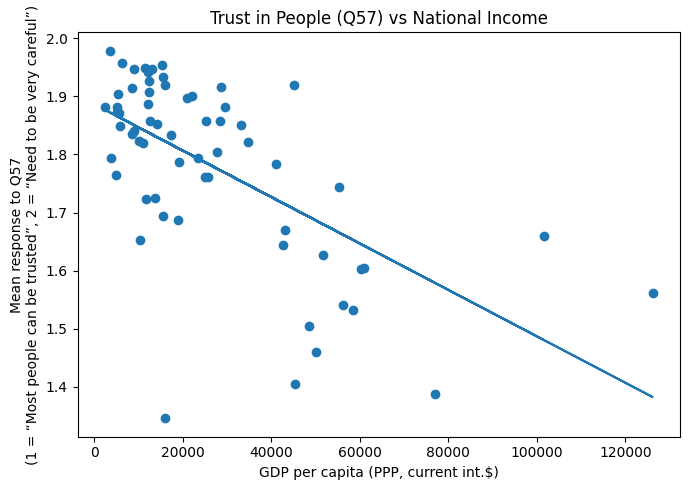

In [3]:
#Trust In People (Q57) Vs National Income
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Load the merged WVS + GDP file
df = pd.read_csv('WVS_GDP_merged_data.csv')

# Select the main trust indicator (Q57) and GDP per‑capita (PPP)
df_plot = df[['Q57', 'GDP_USD_PPP_per_capita']].dropna()

# Build a simple linear regression model
X = sm.add_constant(df_plot['GDP_USD_PPP_per_capita'])
model = sm.OLS(df_plot['Q57'], X).fit()

# Create the scatter‑plot and regression line
plt.figure(figsize=(7, 5))
plt.scatter(df_plot['GDP_USD_PPP_per_capita'], df_plot['Q57'])
pred_line = model.predict(X)
plt.plot(df_plot['GDP_USD_PPP_per_capita'], pred_line)

plt.xlabel('GDP per capita (PPP, current int.$)')
plt.ylabel('Mean response to Q57\n(1 = “Most people can be trusted”, 2 = “Need to be very careful”)')
plt.title('Trust in People (Q57) vs National Income')
plt.tight_layout()
plt.show()


In [6]:
#Trust–Income Correlations

trust_vars = [f'Q{i}' for i in range(57, 79)]
corrs = {
    v: df[[v, 'GDP_USD_PPP_per_capita']].dropna().corr().iloc[0, 1]
    for v in trust_vars
}
corr_df = pd.DataFrame.from_dict(corrs, orient='index', columns=['r']).sort_index()

corr_df


,r
Q57,-0.619829
Q58,0.023631
Q59,-0.144313
Q60,-0.496573
Q61,-0.461552
Q62,-0.476477
Q63,-0.609731
Q64,0.564868
Q65,0.036794
Q66,0.005502


In [9]:
#Model Comparison
import pandas as pd
import statsmodels.api as sm
from scipy import stats

# Load data
df = pd.read_csv('WVS_GDP_merged_data.csv')

y = df['GDP_USD_PPP_per_capita']

trust_vars = [f'Q{i}' for i in range(57, 79)]

# ---------- 1. Simple regressions ----------
simple_results = []
for v in trust_vars:
    sub = df[[v, 'GDP_USD_PPP_per_capita']].dropna()
    xv = sm.add_constant(sub[[v]])
    yv = sub['GDP_USD_PPP_per_capita']
    model_v = sm.OLS(yv, xv).fit()
    simple_results.append({
        'Question': v,
        'r': sub.corr().iloc[0,1],
        'Slope ($/unit)': model_v.params[v],
        'p‑value': model_v.pvalues[v]
    })

simple_df = (pd.DataFrame(simple_results)
             .set_index('Question')
             .sort_values('p‑value'))

simple_df

best_var = simple_df.index[0]

# ---------- 2. Multiple regression with all trust vars ----------
sub_multi = df[['GDP_USD_PPP_per_capita'] + trust_vars].dropna()
X_multi = sm.add_constant(sub_multi[trust_vars])
y_multi = sub_multi['GDP_USD_PPP_per_capita']
multi_model = sm.OLS(y_multi, X_multi).fit()

# ---------- 3. Single‑predictor model ----------
sub_single = df[[best_var, 'GDP_USD_PPP_per_capita']].dropna()
X_single = sm.add_constant(sub_single[[best_var]])
y_single = sub_single['GDP_USD_PPP_per_capita']
single_model = sm.OLS(y_single, X_single).fit()

compare_df = pd.DataFrame({
    'R²': [multi_model.rsquared, single_model.rsquared],
    'Adj. R²': [multi_model.rsquared_adj, single_model.rsquared_adj],
    'AIC': [multi_model.aic, single_model.aic],
    'BIC': [multi_model.bic, single_model.bic]
}, index=['All 22 trust questions', f'Single ({best_var})'])

compare_df


,R²,Adj. R²,AIC,BIC
All 22 trust questions,0.585528,0.345570,1395.610322,1444.160421
Single (Q57),0.384188,0.374093,1422.606886,1426.893155


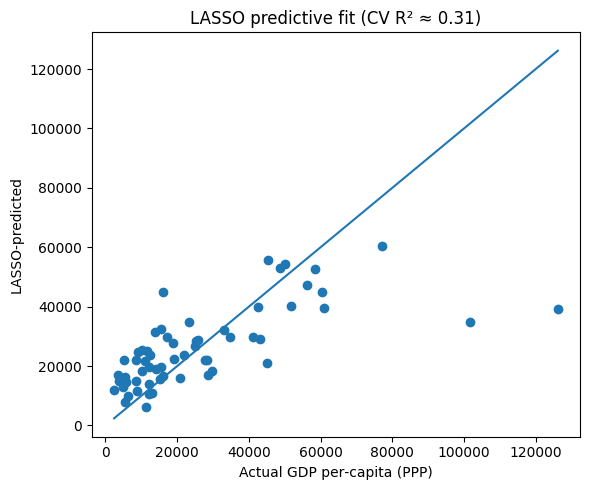

In [11]:
#Lasso predictive fit
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt

# ---------- prepare data ----------
df = pd.read_csv('WVS_GDP_merged_data.csv')
trust_vars = [f'Q{i}' for i in range(57, 79)]
sub = df[['GDP_USD_PPP_per_capita'] + trust_vars].dropna()
X = sub[trust_vars].values
y = sub['GDP_USD_PPP_per_capita'].values

# ---------- LASSO with cross‑validation ----------
pipe = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=42, max_iter=10000))
pipe.fit(X, y)
lasso = pipe.named_steps['lassocv']

# CV R² (5‑fold, negative MSE converted)
cv_r2 = cross_val_score(pipe, X, y, cv=5, scoring='r2').mean()

# collect coefficients (after standardisation)
coef = pd.Series(lasso.coef_, index=trust_vars)
selected = coef[coef.abs() > 1e-6].sort_values(key=np.abs, ascending=False)

selected

# ---------- diagnostic scatter ----------
y_pred = pipe.predict(X)

plt.figure(figsize=(6,5))
plt.scatter(y, y_pred)
lims = [y.min(), y.max()]
plt.plot(lims, lims)
plt.xlabel('Actual GDP per‑capita (PPP)')
plt.ylabel('LASSO‑predicted')
plt.title(f'LASSO predictive fit (CV R² ≈ {cv_r2:.2f})')
plt.tight_layout()
plt.show()


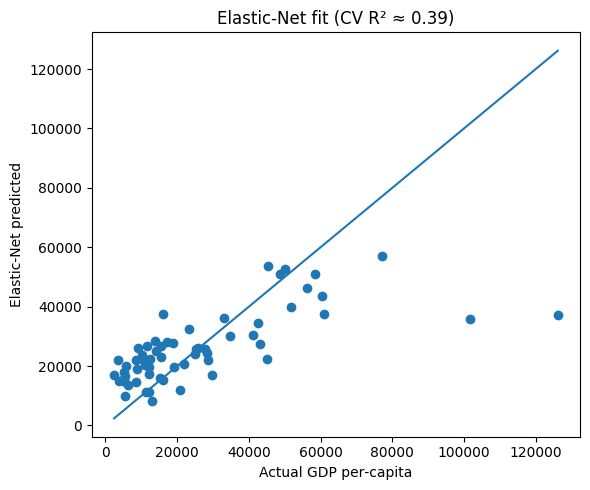

In [12]:
#Elastic net 
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

# -------- data --------
df = pd.read_csv('WVS_GDP_merged_data.csv')
trust_vars = [f'Q{i}' for i in range(57, 79)]
sub = df[['GDP_USD_PPP_per_capita'] + trust_vars].dropna()
X = sub[trust_vars].values
y = sub['GDP_USD_PPP_per_capita'].values

# -------- Elastic‑Net (CV over alpha & l1_ratio) --------
enet_pipe = make_pipeline(
    StandardScaler(),
    ElasticNetCV(
        l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9, 1.0],   # 1.0 = LASSO, 0 = Ridge
        cv=5,
        random_state=42,
        max_iter=10000
    )
)
enet_pipe.fit(X, y)
enet = enet_pipe.named_steps['elasticnetcv']

cv_r2 = cross_val_score(enet_pipe, X, y, cv=5, scoring='r2').mean()

coef = pd.Series(enet.coef_, index=trust_vars)
selected = coef[coef.abs() > 1e-6].sort_values(key=np.abs, ascending=False)

selected

# Scatter plot
y_pred = enet_pipe.predict(X)
plt.figure(figsize=(6,5))
plt.scatter(y, y_pred)
lims = [y.min(), y.max()]
plt.plot(lims, lims)
plt.xlabel('Actual GDP per‑capita')
plt.ylabel('Elastic‑Net predicted')
plt.title(f'Elastic‑Net fit (CV R² ≈ {cv_r2:.2f})')
plt.tight_layout()
plt.show()


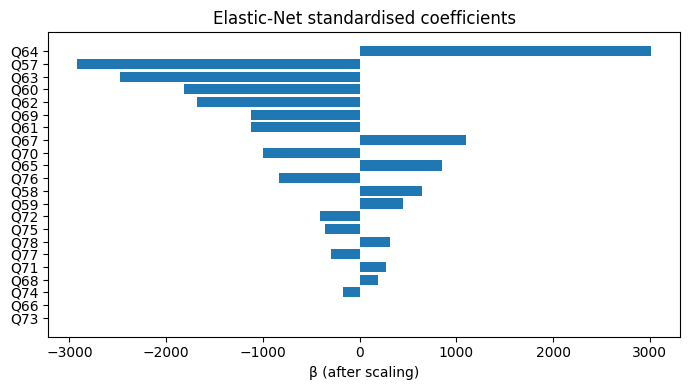

C:\Users\justl\AppData\Local\Temp\ipykernel_17908\821293938.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(xv, ols_params[0] + ols_params[1]*xv)


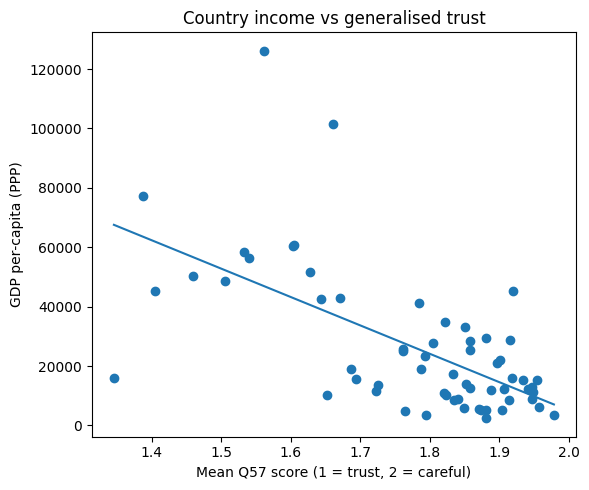

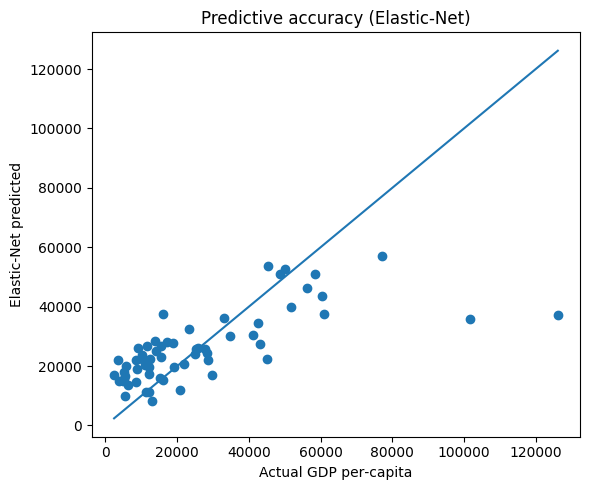

In [13]:
#Visual representation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# ---------- prepare data ----------
df = pd.read_csv('WVS_GDP_merged_data.csv')
trust_vars = [f'Q{i}' for i in range(57, 79)]
sub = df[['GDP_USD_PPP_per_capita'] + trust_vars].dropna()
X = sub[trust_vars].values
y = sub['GDP_USD_PPP_per_capita'].values

# ---------- fit elastic‑net again (same CV grid) ----------
pipe = make_pipeline(
    StandardScaler(),
    ElasticNetCV(l1_ratio=[0.1,0.3,0.5,0.7,0.9,1.0],
                 cv=5,
                 random_state=42,
                 max_iter=10000)
)
pipe.fit(X, y)
enet = pipe.named_steps['elasticnetcv']
coef = pd.Series(enet.coef_, index=trust_vars)
sel = coef[coef.abs() > 1e-6].sort_values(key=np.abs, ascending=True)

# ---------- 1. Bar chart of selected coefficients ----------
plt.figure(figsize=(7,4))
plt.barh(sel.index, sel.values)
plt.title('Elastic‑Net standardised coefficients')
plt.xlabel('β (after scaling)')
plt.tight_layout()
plt.show()


# ---------- 2. Scatter plot GDP vs Q57 with OLS line ----------
from statsmodels.api import OLS, add_constant
plt.figure(figsize=(6,5))
plt.scatter(sub['Q57'], y)

xv = np.linspace(sub['Q57'].min(), sub['Q57'].max(), 50)
ols_params = OLS(y, add_constant(sub['Q57'])).fit().params
plt.plot(xv, ols_params[0] + ols_params[1]*xv)

plt.xlabel('Mean Q57 score (1 = trust, 2 = careful)')
plt.ylabel('GDP per‑capita (PPP)')
plt.title('Country income vs generalised trust')
plt.tight_layout()
plt.show()


# ---------- 3. Predicted vs actual (elastic‑net) ----------
y_pred = pipe.predict(X)

plt.figure(figsize=(6,5))
plt.scatter(y, y_pred)
lims = [y.min(), y.max()]
plt.plot(lims, lims)
plt.xlabel('Actual GDP per‑capita')
plt.ylabel('Elastic‑Net predicted')
plt.title('Predictive accuracy (Elastic‑Net)')
plt.tight_layout()
plt.show()


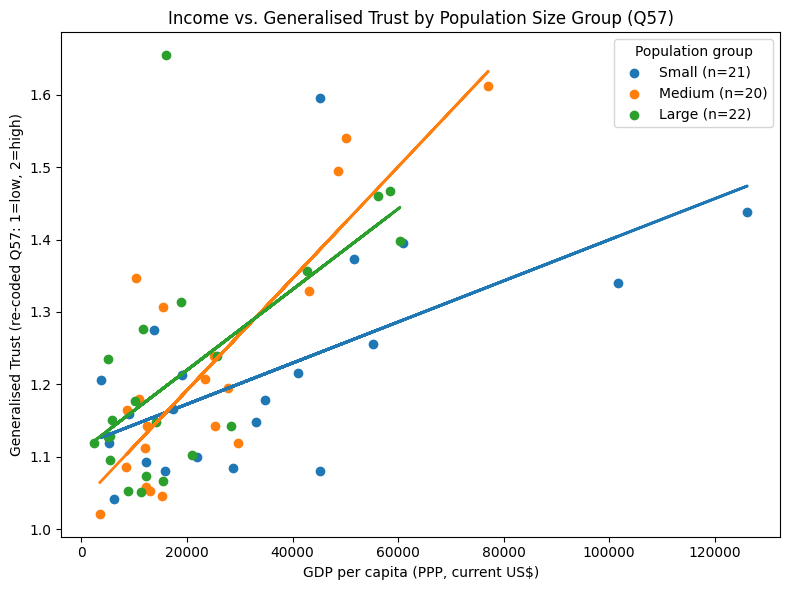

Small countries: slope = 2.837e-06, intercept = 1.116, Pearson r = 0.63, p = 0.002, n = 21
Medium countries: slope = 7.714e-06, intercept = 1.038, Pearson r = 0.84, p = 0.000, n = 20
Large countries: slope = 5.565e-06, intercept = 1.108, Pearson r = 0.63, p = 0.002, n = 22


In [16]:
#Graph 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Load data
df = pd.read_csv('WVS_GDP_merged_data.csv')

# Recode Q57 (general trust) from 1=trust completely, 2=don't trust
# to a scale where higher = more trust: new = 3 - original
df['Q57_rev'] = 3 - df['Q57']

# Filter complete cases for Q57_rev, GDP, and Population
mask = df['Q57_rev'].notna() & df['GDP_USD_PPP_per_capita'].notna() & df['Population'].notna()
df_clean = df.loc[mask, ['GDP_USD_PPP_per_capita', 'Q57_rev', 'Population']].copy()

# Create population tertiles
tertiles = np.percentile(df_clean['Population'], [33, 66])
bins = [0, tertiles[0], tertiles[1], df_clean['Population'].max()]
labels = ['Small', 'Medium', 'Large']
df_clean['pop_group'] = pd.cut(df_clean['Population'], bins=bins, labels=labels, include_lowest=True)

# Plot scatter with regression lines for each group
plt.figure(figsize=(8,6))
results = []
for group in labels:
    sub = df_clean[df_clean['pop_group'] == group]
    x = sub['GDP_USD_PPP_per_capita']
    y = sub['Q57_rev']
    # Fit linear model
    slope, intercept = np.polyfit(x, y, 1)
    # Pearson correlation for p-value
    r, p = pearsonr(x, y)
    results.append((group, slope, intercept, r, p, len(sub)))
    
    # Plot
    plt.scatter(x, y, label=f"{group} (n={len(sub)})")
    plt.plot(x, intercept + slope * x, linewidth=2)

plt.xlabel("GDP per capita (PPP, current US$)")
plt.ylabel("Generalised Trust (re-coded Q57: 1=low, 2=high)")
plt.title("Income vs. Generalised Trust by Population Size Group (Q57)")
plt.legend(title="Population group")
plt.tight_layout()
plt.show()

# Print regression details
for grp, slope, intercept, r, p, n in results:
    print(f"{grp} countries: slope = {slope:.3e}, intercept = {intercept:.3f}, "
          f"Pearson r = {r:.2f}, p = {p:.3f}, n = {n}")
